# Pokemon trainer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import ast
import math

In [ ]:
# RUN TO CREATE CLEANED CSV FILES
""" pokedf = None
with open('pokemon-data.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    pokemon = []
    colNames = []
    for row in reader:
        pokemon.append(' '.join(row).split(';'))
    colNames = pokemon[0]
    pokemon.pop(0)
    pokedf = pd.DataFrame(pokemon, columns=colNames)

pokedf.drop(['Tier', 'Next Evolution(s)'], axis=1, inplace=True)
pokedf.to_csv('pokemon-data-clean.csv', index=False) """

""" movedf = pd.read_csv('move-data.csv')
movedf.drop(['Index', 'Generation'], axis=1, inplace=True)
movedf.to_csv('move-data-clean.csv', index=False)
 """

### Create Dataframes for pokemon dataset, move dataset and type dataset

In [2]:
def cleanup(arr):
    newArr = []
    for move in arr:
        newName = (move.replace('-', '')).replace("'", '') # Remove dashes
        if movedf[movedf['Name'] == newName]['Category'].values[0] == 'Status': # Remove status moves
            continue

        # Remove moves with no power or accuracy
        if np.isnan(movedf[movedf['Name'] == newName]['Power'].values[0]) or np.isnan(movedf[movedf['Name'] == newName]['Accuracy'].values[0]):
            continue
        
        newArr.append(newName) 
    return newArr 

def standardize(row):
    factor = 600 / (row['HP'] + row['Attack'] + row['Defense'] + row['Special Attack'] + row['Special Defense'] + row['Speed'])
    row['HP'] = math.floor(factor * row['HP'])
    row['Attack'] = math.floor(factor * row['Attack'])
    row['Defense'] = math.floor(factor * row['Defense'])
    row['Special Attack'] = math.floor(factor * row['Special Attack'])
    row['Special Defense'] = math.floor(factor * row['Special Defense'])
    row['Speed'] = math.floor(factor * row['Speed'])
    return row

movedf = pd.read_csv('move-data-clean.csv')
movedf['Name'] = movedf['Name'].apply(lambda x: (x.replace('-', '')).replace("'", '')) # Remove dashes (like in Double-Edge)
movedf['Power'] = movedf['Power'].apply(lambda x: int(x) if x != 'None' else None)
movedf['Accuracy'] = movedf['Accuracy'].apply(lambda x: int(x) if x != 'None' else None)

pokedf = pd.read_csv('pokemon-data-clean.csv')
for col in ['Types', 'Abilities', 'Moves']: # Turn the types, abilities, and moves from a string to a list
    pokedf[col] = pokedf[col].apply(ast.literal_eval)
pokedf = pokedf.apply(standardize, axis=1)
pokedf['Moves'] = pokedf['Moves'].apply(cleanup)

typedf = pd.read_csv('type-data-clean.csv', index_col=0)

allTypes = ['Normal', 'Fire', 'Water', 'Electric', 'Grass', 'Ice', 'Fighting', 'Poison', 'Ground', 'Flying', 'Psychic', 'Bug', 'Rock', 'Ghost', 'Dragon', 'Dark', 'Steel', 'Fairy']
allCategories = ['Physical', 'Special']

In [ ]:
# Verify dataframe is formatted correctly
print(pokedf)

## Experiment 1: Type Classifier
### Given the moves a pokemon will learn, can we predict its type?
1) Replace the moves with the move type, and count the number of moves in each type

2) Perform varying methods of supervised classification to find the optimal classifier and how quickly it will learn

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
# Given abilties, predict type
def getMoveType(x): # Input: list of moves, Output: list of move types
    return movedf[movedf['Name'] == x]['Type'].values[0]

# Create dictionary for each pokemon where keys are move type and value is number of moves with type key 
allVectorTypes = []
allVectorLabels = []
i = 0
for index in range(len(pokedf)):
    if i % 10 == 0:
        print(str(index) + "/" + str(len(pokedf)))
    pokeType = pokedf.loc[index, 'Types'][0]
    moves = pokedf.loc[index, 'Moves']
    moveTypes = list(map(getMoveType, moves))
    uniques, counts = np.unique(moveTypes, return_counts=True)
    vectorTypes = {type: 0 for type in allTypes}
    for i in range(len(uniques)):
        vectorTypes[uniques[i]] = counts[i]
    allVectorTypes.append(vectorTypes)
    allVectorLabels.append(allTypes.index(pokeType))
    i += 1

dVect = DictVectorizer()
dVectTypes = dVect.fit_transform(allVectorTypes).toarray()

0/918
1/918
2/918
22/918
23/918
31/918
40/918
42/918
45/918
54/918
55/918
56/918
83/918
91/918
100/918
114/918
120/918
121/918
124/918
139/918
141/918
148/918
154/918
169/918
175/918
178/918
196/918
197/918
199/918
206/918
210/918
220/918
225/918
240/918
244/918
254/918
257/918
258/918
283/918
297/918
305/918
306/918
307/918
308/918
313/918
330/918
335/918
336/918
338/918
343/918
360/918
387/918
393/918
418/918
426/918
441/918
453/918
457/918
475/918
478/918
489/918
490/918
507/918
509/918
514/918
524/918
527/918
538/918
540/918
572/918
575/918
576/918
577/918
582/918
614/918
617/918
618/918
619/918
620/918
625/918
626/918
629/918
633/918
635/918
643/918
673/918
676/918
677/918
678/918
687/918
695/918
696/918
721/918
725/918
729/918
730/918
733/918
740/918
748/918
754/918
757/918
759/918
762/918
763/918
764/918
765/918
766/918
773/918
782/918
783/918
788/918
802/918
804/918
819/918
826/918
827/918
850/918
858/918
873/918
875/918
883/918
887/918
891/918
903/918


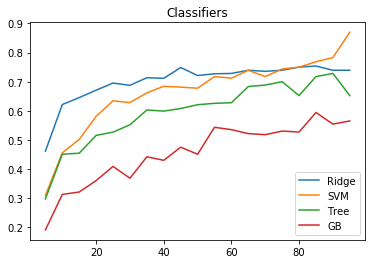

In [12]:
def RidgeReg(X_train, X_test, y_train, y_test):
    rdg = RidgeClassifier()
    rdg.fit(X_train, y_train)
    return rdg.score(X_test, y_test)

def SVM(X_train, X_test, y_train, y_test):
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

def DecTree(X_train, X_test, y_train, y_test):
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    return dt.score(X_test, y_test)

def GaussianBayes(X_train, X_test, y_train, y_test):
    gb = GaussianNB()
    gb.fit(X_train, y_train)
    return gb.score(X_test, y_test)

for key, classifier in {"Ridge": RidgeReg, "SVM": SVM, "Tree": DecTree, "GB": GaussianBayes}.items():
    x = []
    y = []

    for i in range(1, 20):
        index = math.floor(len(dVectTypes) * i/20)
        X_train = dVectTypes[:index]
        X_test = dVectTypes[index:]

        y_train = allVectorLabels[:index]
        y_test = allVectorLabels[index:]

        x.append(i * 5)
        y.append(classifier(X_train, X_test, y_train, y_test))

    """ for i in range(20, len(allVectorLabels), 20):
        X_train = dVectTypes[:i]
        X_test = dVectTypes[i:]

        y_train = allVectorLabels[:i]
        y_test = allVectorLabels[i:]

        x.append(i)
        y.append(classifier(X_train, X_test, y_train, y_test)) """
    plt.plot(x, y, label=key)

plt.title("Classifiers")
plt.legend()
plt.show()